In [71]:
#import os
#os.environ["MKL_NUM_THREADS"] = "3"

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import george
import emcee
import scipy.stats
import pandas as pd


import plotting

import argparse
import textwrap


def read_data(filename, datadir="./"):
    """
    Read in light curve data from asteroid.
    """

    data  = pd.read_csv(datadir+filename, header=None, delim_whitespace=False)

    tsample = data[0]
    fsample = data[1]
    flux_err = data[2]

    return tsample, fsample, flux_err


class GPFit():
    def __init__(self, time_stamps, flux, flux_error):
        self.time = time_stamps
        self.flux = flux
        self.flux_err = flux_error
        self.data_pts = len(time_stamps)
        self.true_period = None
        self.params = None
        self.walker_params = None
        self.gp = None
        self.sampler = None

    def set_params(self):
        """Calculates initial gp parameter values based on data."""
        mean_flux = np.mean(self.flux)
        log_amp = np.log(self.flux.max()-self.flux.min())
        gamma = 1
        log_period = 0

        parameters = {"mean": mean_flux, "log_amp": log_amp, "gamma": gamma,"log_period": log_period}
        self.params = parameters
        return


    def set_walker_param_matrix(self, nwalkers):
        """Creates a matrix of starting parameters for every walker."""

        if self.params is not None:

            p_start = np.array(list(self.params.values()))
            cov_matrix = np.sqrt(np.diag(p_start)**2)
            p0 = np.random.multivariate_normal(mean=p_start, cov=cov_matrix, size=(nwalkers))

            # equally distributed starting period values
            p0[:,3] = np.log(np.linspace(2,12,nwalkers)/24.)

            self.walker_params = p0

        else:
            print("Please set parameter values first.")

        return

    def set_gp_kernel(self):
        """Sets up the Gaussian Process Kernel that is needed for george."""

        kernel = np.exp(self.params["log_amp"]) * george.kernels.ExpSine2Kernel(gamma = self.params["gamma"], log_period = self.params["log_period"])
        gp = george.GP(kernel, fit_mean=True, mean=self.params["mean"])
        gp.compute(self.time, self.flux_err)

        self.gp = gp

        return

    def run_emcee(self, nwalkers, niter, threads=1):
        """Runs emcee's mcmc code."""

        ndim = 4
        sampler = emcee.EnsembleSampler(nwalkers, ndim, post_lnlikelihood, args=[self.gp, self.time, self.flux, self.flux_err], threads=threads)

        mcmc_sampling = sampler.run_mcmc(self.walker_params, niter)
        self.sampler = sampler

        return sampler

    def run_lsp(self, true_period, nterms):
        """Determines the Lomb-Scargle Periodogram."""

        from scipy.signal import argrelextrema

        #get l-s best period estimate
        from lombscargle import make_lsp
        from astropy.stats import LombScargle

        freq, power = make_lsp(self.time, self.flux, self.flux_err, p_max=5.0, nterms=nterms)

        # determine the indices of local power maxima
        best_idx = argrelextrema(power, np.greater)

        # sort these indices based on actual power value
        # reverse list so max is read first
        indices = np.argsort(power[best_idx[0]])[::-1]

        # sort our original indices based on the new
        # power-sorted indices
        best_idx = (best_idx[0]).T[indices]
        best_freqs = freq[best_idx].T

        new_freq = best_freqs[0]
        new_period = 1./new_freq
        new_log_period = np.log(1./new_freq)

        self.true_period = true_period

        # plot all the frequencies
        fig, (ax, bx) = plt.subplots(1,2, figsize=(12,5))
        fig.set_tight_layout('tight')
        ax.plot((1./freq)*24.,power)
        ax.set_xlabel('Period (hrs)')
        ax.vlines(new_period*24., 0, 1, colors='orange', linestyles='--',
                  label = 'Best fit : ' + str(round(new_period*24., 5)))
        ax.vlines(true_period, 0, 1, colors='blue', linestyles='--',
                  label = 'True fit : ' + str(true_period))
        ax.set_xlim([0,24])
        ax.legend()

        bx = plotting.plot_folded_lightcurve(self.time, self.flux, period=new_period, ax=bx)


        namestr=filename + "_plots"
        plt.savefig(namestr + "_lsp.pdf", format="pdf")

        return

    def daniela_lsp(self, true_period, nterms):
        """Testing out Daniela's LSP method."""

        ax = plotting.plot_lsp(self.time, self.flux, self.flux_err, p_max=5.0, true_period=true_period,
                                nterms=nterms)
        
        #bx = plotting.plot_folded_lightcurve(self.time, self.flux, period=new_period, ax=bx)

        namestr=filename + "_plots_daniela"
        plt.savefig(namestr + "_lsp.pdf", format="pdf")

        return


def main():

    # read in the data file
    time, flux, flux_err= read_data(filename, datadir)

    asteroid = GPFit(time, flux, flux_err)
    asteroid.daniela_lsp(true_period, nterms)
    #asteroid.set_params()
    #asteroid.set_walker_param_matrix(nwalkers)
    #asteroid.set_gp_kernel()

    #sampler = asteroid.run_emcee(niter=niter, nwalkers=nwalkers, threads=threads)

    #plot_mcmc_sampling_results(np.array(asteroid.time), asteroid.flux, asteroid.flux_err,
    #                           asteroid.gp, sampler, namestr=filename + "_plots",
    #                           true_period=true_period)


    return


In [72]:
 # read in the data file
    
filename = "../data/simulation_results_new/221/221_lc_49627_to_49787.txt_sampled_ztf-lsst_60days.txt"
datadir = ""
true_period = None
nterms = 2

    
time, flux, flux_err= read_data(filename, datadir)


In [73]:
asteroid = GPFit(time, flux, flux_err)

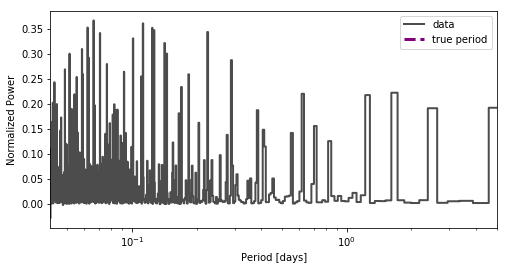

In [74]:
asteroid.daniela_lsp(true_period, nterms)